In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.pyplot as mticker

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)
# add in inspector 
inspector = inspect(engine)

# Check out tables

In [13]:
# Use inspect to set what columns are in the table
columns = inspector.get_columns('station')
for i in columns:
    print(i["name"], i["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# check out the table in more depth
engine.execute('select * from station limit 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [15]:
#inspect the columns in the second table
columns2 = inspector.get_columns('measurement')
for i in columns2:
    print(i['name'], i['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
# check out table 2 in more depth
engine.execute('select * from measurement order by date DESC limit 10 ').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0)]

# Exploratory Climate Analysis

In [17]:
#How many dates are there: 
session.query(func.count(measurement.date)).all()
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
last12_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last12_precip_df = pd.DataFrame(last12_precip)
# set date to index
last12_precip_df.set_index('date', inplace = True)

# Sort the dataframe by date
sorted_lastyear = last12_precip_df.sort_values('date')
sorted_lastyear.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


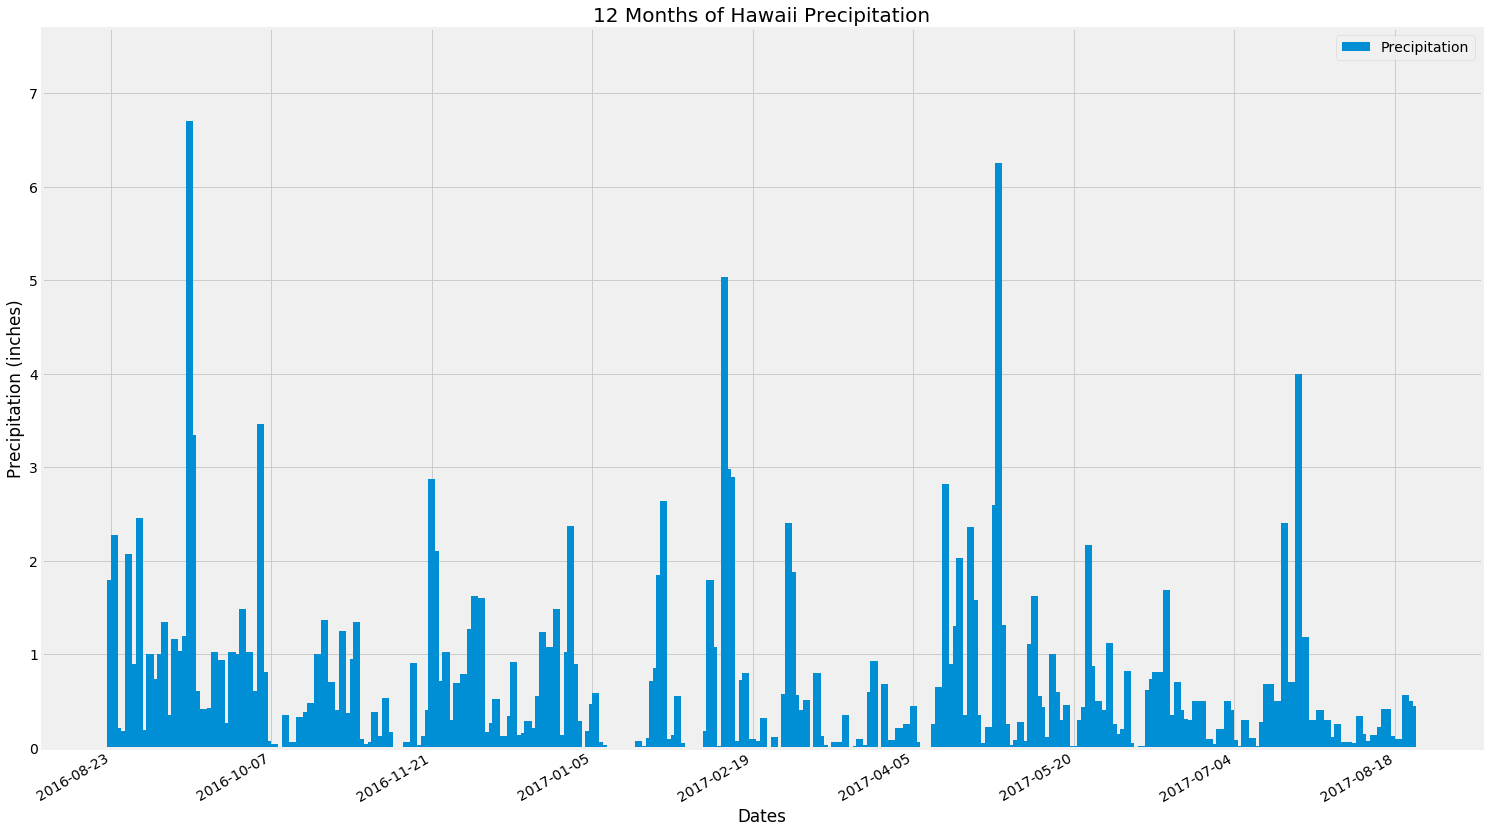

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
#set my blank slate with size:
fig = plt.figure(figsize=(20,10), facecolor = 'w') 
ax = fig.add_axes([0,0,1,1])
# set bargraph x and y axes
ax.bar(sorted_lastyear.index.values, sorted_lastyear['prcp'],width=2)
# set a y-lim
plt.ylim(0,max(sorted_lastyear['prcp']+1))
# set labels, title and legend
ax.set_xlabel('Dates')
ax.set_ylabel('Precipitation (inches)')
ax.set_title('12 Months of Hawaii Precipitation', size=20)
ax.legend(['Precipitation'], loc='best')
# format the tick labels 
fig.autofmt_xdate()
myLocator = mticker.MultipleLocator(45)
ax.xaxis.set_major_locator(myLocator)
#plot the figure
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = sorted_lastyear.describe()
summary_stats.round(2)

,prcp
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [21]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurement).group_by(measurement.station).count()
station_count

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_records = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
station_records
#for a,b in station_records:#the parenthesis are not required around a,b
    #print(b)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stats = session.query(measurement.station, func.min(measurement.tobs),\
    func.max(measurement.tobs),\
    func.avg(measurement.tobs)).\
    filter_by(station = 'USC00519281').all()
for a,b,c,d in stats:
    print(f'''=============
Station {a} has the highest number of recordings; \n\
from those recordings, the lowest temp record is {round((b),2)}\n\
the highest temp record is {round((c),2)}\n\
the average temp is {round((d),2)}'
=============''')


Station USC00519281 has the highest number of recordings; 
from those recordings, the lowest temp record is 54.0
the highest temp record is 85.0
the average temp is 71.66'


In [24]:
# Choose the station with the highest number of temperature observations.
temps = session.query(measurement.tobs,measurement.date).\
    filter(measurement.date >= one_year_ago).\
    filter_by(station = 'USC00519281').all()

Text(0, 0.5, 'Frequency')

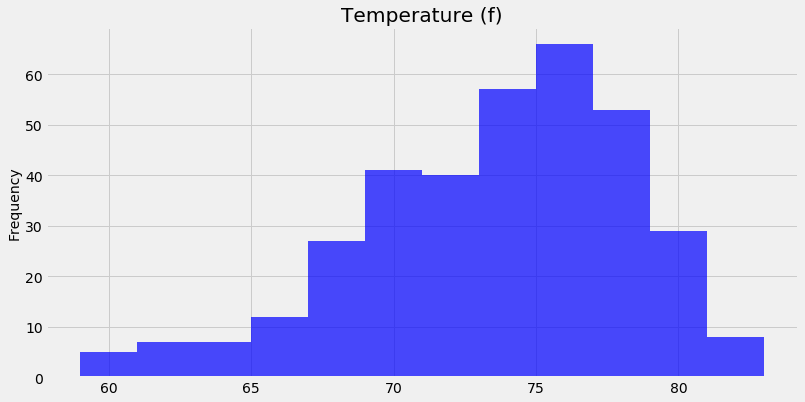

In [25]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps12_df = pd.DataFrame(temps, columns=['Temperature (f)','Date'])
temps12_df.hist(color = 'b', alpha = .70, rwidth = 1, bins = 12, figsize = (12,6), grid = True)
plt.ylabel("Frequency", fontsize=14)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [38]:
results = session.query(measurement.station,measurement.date,measurement.tobs).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.station == 'USC00519281').all()


[('USC00519281', '2016-08-23', 77.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0),
 ('USC00519281', '2016-09-02', 80.0),
 ('USC00519281', '2016-09-03', 78.0),
 ('USC00519281', '2016-09-04', 78.0),
 ('USC00519281', '2016-09-05', 78.0),
 ('USC00519281', '2016-09-06', 73.0),
 ('USC00519281', '2016-09-07', 74.0),
 ('USC00519281', '2016-09-08', 80.0),
 ('USC00519281', '2016-09-09', 79.0),
 ('USC00519281', '2016-09-10', 77.0),
 ('USC00519281', '2016-09-11', 80.0),
 ('USC00519281', '2016-09-12', 76.0),
 ('USC00519281', '2016-09-13', 79.0),
 ('USC00519281', '2016-09-14', 75.0),
 ('USC00519281', '2016-09-15', 79.0),
 ('USC00519281', '2016-09-16', 78.0),
 ('USC00519281', '2016-09-17', 79.0),
 ('USC005192

In [53]:
testy = session.query(measurement.station,measurement.date, func.min(measurement.tobs),\
    func.max(measurement.tobs),\
    func.avg(measurement.tobs)).\
    group_by(measurement.date).all()
testy

[('USC00519523', '2010-01-01', 65.0, 75.0, 69.71428571428571),
 ('USC00519523', '2010-01-02', 61.0, 75.0, 67.0),
 ('USC00519523', '2010-01-03', 67.0, 77.0, 74.0),
 ('USC00519397', '2010-01-04', 72.0, 76.0, 75.0),
 ('USC00513117', '2010-01-05', 73.0, 76.0, 74.5),
 ('USC00513117', '2010-01-06', 71.0, 76.0, 73.33333333333333),
 ('USC00516128', '2010-01-07', 68.0, 74.0, 70.42857142857143),
 ('USC00518838', '2010-01-08', 63.0, 73.0, 65.57142857142857),
 ('USC00519281', '2010-01-09', 67.0, 70.0, 68.57142857142857),
 ('USC00519281', '2010-01-10', 70.0, 75.0, 72.71428571428571),
 ('USC00518838', '2010-01-11', 64.0, 72.0, 66.71428571428571),
 ('USC00516128', '2010-01-12', 57.0, 68.0, 61.57142857142857),
 ('USC00518838', '2010-01-13', 57.0, 68.0, 61.5),
 ('USC00516128', '2010-01-14', 65.0, 69.0, 66.42857142857143),
 ('USC00513117', '2010-01-15', 56.0, 69.0, 64.83333333333333),
 ('USC00513117', '2010-01-16', 65.0, 71.0, 67.33333333333333),
 ('USC00519523', '2010-01-17', 64.0, 70.0, 68.0),
 ('USC0

In [41]:
sel = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]

    high_low_avg = session.query(*sel).filter(func.strftime("%Y-%m-%d", measurement.date) >= start).\
        group_by(measurement.date).all()

[('2010-01-01', 65.0, 75.0, 69.71428571428571),
 ('2010-01-02', 61.0, 75.0, 67.0),
 ('2010-01-03', 67.0, 77.0, 74.0),
 ('2010-01-04', 72.0, 76.0, 75.0),
 ('2010-01-05', 73.0, 76.0, 74.5),
 ('2010-01-06', 71.0, 76.0, 73.33333333333333),
 ('2010-01-07', 68.0, 74.0, 70.42857142857143),
 ('2010-01-08', 63.0, 73.0, 65.57142857142857),
 ('2010-01-09', 67.0, 70.0, 68.57142857142857),
 ('2010-01-10', 70.0, 75.0, 72.71428571428571),
 ('2010-01-11', 64.0, 72.0, 66.71428571428571),
 ('2010-01-12', 57.0, 68.0, 61.57142857142857),
 ('2010-01-13', 57.0, 68.0, 61.5),
 ('2010-01-14', 65.0, 69.0, 66.42857142857143),
 ('2010-01-15', 56.0, 69.0, 64.83333333333333),
 ('2010-01-16', 65.0, 71.0, 67.33333333333333),
 ('2010-01-17', 64.0, 70.0, 68.0),
 ('2010-01-18', 70.0, 77.0, 73.0),
 ('2010-01-19', 61.0, 75.0, 69.42857142857143),
 ('2010-01-20', 66.0, 72.0, 67.85714285714286),
 ('2010-01-21', 68.0, 71.0, 69.5),
 ('2010-01-22', 60.0, 67.0, 63.5),
 ('2010-01-23', 67.0, 78.0, 73.83333333333333),
 ('2010-01-24